Google Drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [2]:
!pip install livelossplot -q

# Imports

In [3]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
import pandas as pd
import os
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass

Number of available GPUs: 1


# Paths

In [4]:
SRC_DIR = Path('/content/drive/MyDrive/TAI/III/nlp/')
DATA_DIR = SRC_DIR / "data"
LOG_DIR = SRC_DIR / 'logs'
BEST_MODEL_DIR = LOG_DIR / "checkpoints"
TENSOR_BOARD_DIR = LOG_DIR / "tensor_board"

# Dataset

## Load dataset

In [5]:
fake_news_df = pd.read_csv(os.path.join(DATA_DIR, "GettingRealAboutFakeNews/fake.csv"))

## Dataset info

In [6]:
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                12999 non-null  object 
 1   ord_in_thread       12999 non-null  int64  
 2   author              10575 non-null  object 
 3   published           12999 non-null  object 
 4   title               12319 non-null  object 
 5   text                12953 non-null  object 
 6   language            12999 non-null  object 
 7   crawled             12999 non-null  object 
 8   site_url            12999 non-null  object 
 9   country             12823 non-null  object 
 10  domain_rank         8776 non-null   float64
 11  thread_title        12987 non-null  object 
 12  spam_score          12999 non-null  float64
 13  main_img_url        9356 non-null   object 
 14  replies_count       12999 non-null  int64  
 15  participants_count  12999 non-null  int64  
 16  like

In [7]:
fake_news_df.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [59]:
fake_news_df['type'].value_counts()

bs            4064
bias           271
conspiracy     163
hate            99
junksci         97
state            6
fake             2
Name: type, dtype: int64

Duplicates and NaNs

In [10]:
fake_news_df.duplicated().sum()

0

In [11]:
fake_news_df.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

## Clean data

### Convert text to lower case and remove punctuation

In [58]:
# convert text columns to lower case
fake_news_df['title'] = fake_news_df['title'].str.lower()
fake_news_df['text'] = fake_news_df['text'].str.lower()

# remove punctuation
fake_news_df['title'] = fake_news_df['title'].replace('[^\w\s]', '')
fake_news_df['text'] = fake_news_df['text'].replace('[^\w\s]', '')

fake_news_df['text'].head()

0    print they should pay all the back all the mon...
1    why did attorney general loretta lynch plead t...
2    red state  \nfox news sunday reported this mor...
3    email kayla mueller was a prisoner and torture...
4    email healthcare reform to make america great ...
Name: text, dtype: object

### Drop NaNs

In [12]:
fake_news_df = fake_news_df.dropna()

## Map type to int

In [15]:
mapping = {'bs': 0, 'bias': 1, 'conspiracy': 2, 'hate':3, 'satire':4, 'state':5, 'junksci':6, 'fake':7}
fake_news_df['type_enc'] = fake_news_df['type']
fake_news_df = fake_news_df.replace({'type_enc': mapping})

<ipython-input-15-dffd54a6ea84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_df['type_enc'] = fake_news_df['type']


## Merge title and text

In [61]:
fake_news_df['text_combined'] = fake_news_df['title'] + fake_news_df['text']

## Split dataset to train, val and test

Function

In [16]:
from sklearn.model_selection import train_test_split
def split_data(data, labels, valid_part_size = 0.15, test_part_size = 0.15):

    # Split the dataset into train, validation, and test
    X_train, X_test, y_train, y_test = train_test_split(
        data, 
        labels, 
        test_size = test_part_size, 
        stratify = labels, 
        random_state = 1234
        )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, 
        y_train, 
        test_size = valid_part_size/(1 - test_part_size), 
        stratify = y_train, 
        random_state = 1234
        )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [17]:
(X_train, y_train), (X_val, y_val), (X_test,y_test) = split_data(
    fake_news_df['text_combined'], 
    fake_news_df['type_enc'], 
    0.15, 
    0.15
)

### Convert X to list

In [19]:
X_train = tf.constant(X_train.tolist())
X_test = tf.constant(X_test.tolist())
X_val = tf.constant(X_val.tolist())

### Convert Y to categorical

In [20]:
y_test_categorical = tf.keras.utils.to_categorical(y_test.tolist(), num_classes=8, dtype='float32')
y_val_categorical = tf.keras.utils.to_categorical(y_val.tolist(), num_classes=8, dtype='float32')
y_train_categorical = tf.keras.utils.to_categorical(y_train.tolist(), num_classes=8, dtype='float32')

# Model

## Parameters

In [21]:
BATCH_SIZE = 256
EPOCHS = 100
TEST_SPLIT = 0.15
VALID_SPLIT = 0.15
SEED = 1234
VOCABULARY_SIZE = 100000
MAX_SEQUENCE_LEN = 250
EMBEDDING_DIM = 75

## Vectorization layer

In [42]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN
)
vectorize_layer.adapt(X_train, batch_size=BATCH_SIZE)

## Model architecture

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 250, 75)           7500000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              208896    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 7,710,952
Trainable params: 7,710,952
Non-trainable params: 0
_________________________________________________________________


## Metrics

In [44]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
    ]

## Compile

In [45]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics= METRICS 
)

## Callbacks

In [46]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "lstm_best"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=0.001)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=LOG_DIR / "history.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

## Train

In [47]:
history = model.fit(
    X_train, y_train_categorical,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_categorical),
    callbacks=[save_best, early_stop, csv_logger],
    )

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.5070 - accuracy: 0.8009 - recall: 0.2702 - precision: 0.8467 - auc: 0.9074

13/13 [==============================] - 68s 5s/step - loss: 1.5070 - accuracy: 0.8009 - recall: 0.2702 - precision: 0.8467 - auc: 0.9074 - val_loss: 0.6567 - val_accuracy: 0.8640 - val_recall: 0.8640 - val_precision: 0.8640 - val_auc: 0.9455
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9576

13/13 [==============================] - 17s 1s/step - loss: 0.6092 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9576 - val_loss: 0.5869 - val_accuracy: 0.8640 - val_recall: 0.8640 - val_precision: 0.8640 - val_auc: 0.9626
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9656

13/13 [==============================] - 18s 1s/step - loss: 0.5754 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9656 - val_loss: 0.5795 - val_accuracy: 0.8640 - val_recall: 0.8640 - val_precision: 0.8640 - val_auc: 0.9656
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9739

13/13 [==============================] - 17s 1s/step - loss: 0.5552 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9739 - val_loss: 0.5686 - val_accuracy: 0.8640 - val_recall: 0.8640 - val_precision: 0.8640 - val_auc: 0.9691
Epoch 5/100
13/13 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9851

13/13 [==============================] - 18s 1s/step - loss: 0.5056 - accuracy: 0.8644 - recall: 0.8644 - precision: 0.8644 - auc: 0.9851 - val_loss: 0.5333 - val_accuracy: 0.8640 - val_recall: 0.8640 - val_precision: 0.8640 - val_auc: 0.9746
Epoch 6/100
13/13 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8809 - recall: 0.8608 - precision: 0.9258 - auc: 0.9915

13/13 [==============================] - 16s 1s/step - loss: 0.3524 - accuracy: 0.8809 - recall: 0.8608 - precision: 0.9258 - auc: 0.9915 - val_loss: 0.4970 - val_accuracy: 0.8640 - val_recall: 0.7989 - val_precision: 0.9171 - val_auc: 0.9794
Epoch 7/100
13/13 [==============================] - 4s 290ms/step - loss: 0.2307 - accuracy: 0.9143 - recall: 0.8602 - precision: 0.9933 - auc: 0.9965 - val_loss: 0.5018 - val_accuracy: 0.8683 - val_recall: 0.8343 - val_precision: 0.9174 - val_auc: 0.9739
Epoch 8/100
13/13 [==============================] - 4s 295ms/step - loss: 0.1917 - accuracy: 0.9195 - recall: 0.8660 - precision: 0.9979 - auc: 0.9975 - val_loss: 0.5356 - val_accuracy: 0.8654 - val_recall: 0.8229 - val_precision: 0.9208 - val_auc: 0.9716
Epoch 9/100
13/13 [==============================] - 5s 363ms/step - loss: 0.1735 - accuracy: 0.9234 - recall: 0.8860 - precision: 0.9962 - auc: 0.9982 - val_loss: 0.5134 - val_accuracy: 0.8640 - val_recall: 0.8343 - val_precision: 0.9261 - va

## Plot metrics history

In [51]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric_names):
  for n, metric in enumerate(metric_names):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



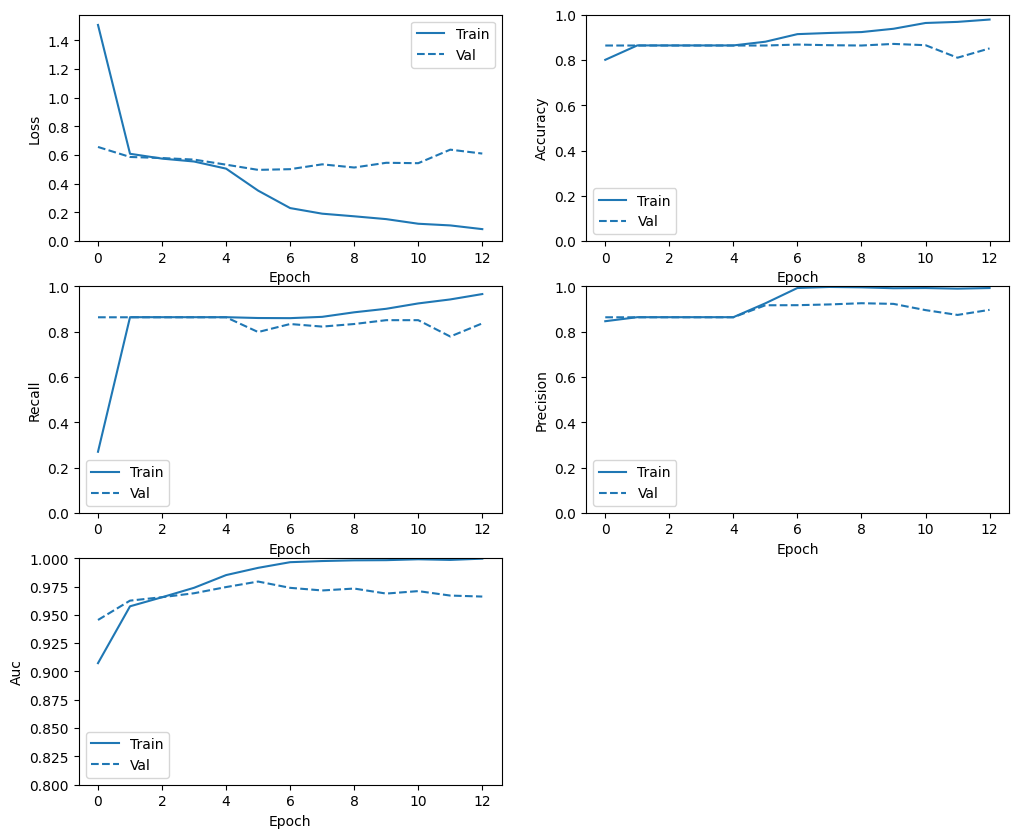

In [55]:
metrics = ["loss", 'accuracy', 'recall', 'precision', 'auc']
plt.figure(figsize=(12,10))
plot_metrics(history, metrics)

# Evaluation

In [56]:
model.evaluate(X_test, y_test_categorical)

23/23 [==============================] - 0s 20ms/step - loss: 0.6015 - accuracy: 0.8456 - recall: 0.8215 - precision: 0.8882 - auc: 0.9672


[0.6014655232429504,
 0.8456090688705444,
 0.821529746055603,
 0.888208270072937,
 0.9671988487243652]